In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# utils

In [2]:
def alpha_transform(data: pd.DataFrame, col: str, max_value: float):
    data = data.reset_index().set_index("date")
    data["mean"] = data.groupby("date")[col].mean()
    data["std"] = data.groupby("date")[col].std()
    data["zscore"] = np.minimum(max_value,np.maximum(-max_value,(data[col] - data["mean"]) / data["std"])).fillna(0)
    data = data.reset_index().set_index(['date', 'permno'])
    return data["zscore"]


def feature_clip(x, col, qmin, qmax):
    return x[col].clip(x[col].quantile(qmin),x[col].quantile(qmax))


def get_quantile_returns(frame, signal_col, n_bins, ret):
    frame[f'{signal_col}Group'] = pd.qcut(frame[signal_col], n_bins, labels=[i + 1 for i in range(n_bins)])
    return frame.groupby(f'{signal_col}Group')[ret].mean()


def get_long_only_returns(frame, signal_col, perc, ret):
    edge = frame[signal_col].quantile(1-perc)
    return frame[frame[signal_col] > edge][ret].mean()


def get_long_only_weight(frame, signal_col, nbins):
    label = frame.groupby('date')[signal_col].transform(lambda x: pd.qcut(x, nbins, labels=range(1, nbins+1))).to_frame()
    label.columns = ['label']
    cnts = label.groupby('date')['label'].transform(lambda x: (x==nbins).sum())
    label = label.join(frame['future_ret'])
    label['weight'] = 0
    label.loc[label['label']==nbins, 'weight'] = 1/cnts
    return label[['weight', 'future_ret']].dropna(subset=['future_ret'])


def get_long_short_returns(frame, signal_col, perc, ret):
    edge_short = frame[signal_col].quantile(perc)
    edge_long = frame[signal_col].quantile(1-perc)
    return frame[frame[signal_col] > edge_long][ret].mean() - frame[frame[signal_col] <= edge_short][ret].mean()


def get_long_short_weight(frame, signal_col, perc, ret):
    edge_short = frame[signal_col].quantile(perc)
    edge_long = frame[signal_col].quantile(1-perc)
    cnt_long = frame[frame[signal_col] > edge_long].shape[0]
    cnt_short = frame[frame[signal_col] <= edge_short].shape[0]
    frame['weight'] = 0
    frame[frame[signal_col] > edge, 'weight'] = 1/cnt_long
    frame[frame[signal_col] <= edge, 'weight'] = 1/cnt_short
    return frame['weight']


def get_long_short_returns_daily(holdings_stk, signal_col, price_vol):
    n_bins = 5
    frame = holdings_stk.copy()
    
    frame[signal_col] = frame[signal_col].fillna(frame.groupby('permno')[signal_col].transform('mean'))
    frame[f'{signal_col}Group'] = frame.groupby('date')[signal_col].apply(lambda x: pd.qcut(x, n_bins, labels=[i + 1 for i in range(n_bins)], duplicates='drop'))
    frame = frame.reset_index()
    frame['group_stock_count'] = frame.groupby(['date', f'{signal_col}Group']).permno.transform('count')
    frame['weight'] = 0
    frame.loc[frame[f'{signal_col}Group'] == 1, 'weight'] = 1/frame.loc[frame[f'{signal_col}Group'] == 1, 'group_stock_count']
    frame.loc[frame[f'{signal_col}Group'] == 5, 'weight'] = -1/frame.loc[frame[f'{signal_col}Group'] == 5, 'group_stock_count']
    
    price_vol = price_vol.reset_index()[price_vol.reset_index()['date'].dt.date >= holdings_stk.reset_index().date[0].date()]
    df = frame[['date', 'permno', 'weight']].merge(price_vol.reset_index()[['date', 'permno', 'ret']], how = 'outer')
    df = df.sort_values(['date', 'permno'])
    df['weight'] = df.groupby('permno')['weight'].ffill()
    df['weight_lag252'] = df.groupby('permno')['weight'].transform(lambda x: x.shift(252))
    df['weight_lag500'] = df.groupby('permno')['weight'].transform(lambda x: x.shift(500))
    daily_ret = df.groupby('date').apply(lambda x: (x['weight']*x['ret']).sum())
    daily_ret_lag252 = df.groupby('date').apply(lambda x: (x['weight_lag252']*x['ret']).sum())
    daily_ret_lag500 = df.groupby('date').apply(lambda x: (x['weight_lag500']*x['ret']).sum())

    ret = pd.concat([daily_ret, daily_ret_lag252, daily_ret_lag500], axis=1)
    ret.columns = ['daily_ret', 'daily_ret_lag252', 'daily_ret_lag500']
    return ret
    
    
def backtest(daily_ret: pd.DataFrame, name: str):
    daily_ret = daily_ret.dropna()
    start_date = daily_ret.index[0].date()
    end_date = daily_ret.index[-1].date()
    ret = daily_ret.mean() * 252
    std = daily_ret.std() * np.sqrt(252)
    n_date = daily_ret.shape[0]
    n_pos_date = (daily_ret>0).sum()
    zero_date = (daily_ret==0).sum()
    n_pos_date += zero_date
    mdd = (daily_ret.cumsum().cummax() - daily_ret.cumsum()).max()
    sharp = ret / std
    stats_dict = { 'start_date' : start_date,
                   'end_date': end_date,
                   'n_days': n_date,
                   'n_pos_day' : n_pos_date,
                   'ret_annual': ret,
                   'std_annual': std,
                   'sharpe': sharp,
                   'mdd': mdd}
    stats = pd.DataFrame(stats_dict, index=[name])
    return stats

## Get data

In [3]:
import pyarrow.parquet as pq

# Specify the path to your parquet.gzip file
parquet_file_path = '../data/hf_netflow.parquet.gzip'

# Read the Parquet file using pyarrow
net_flow = pq.read_table(parquet_file_path)

# Convert the table to a Pandas DataFrame if needed
net_flow = net_flow.to_pandas()

net_flow.head()

,rdate,mgrno,mgrname,first_report,last_report,assets,pret,tbuys,tsales,tgain,tgainret,netflows,turnover1,turnover2,turnover3
0,2015-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,230.559108,-0.000580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-06-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,226.166607,-0.077177,220.872751,0.000000,-17.778290,-0.080491,-4.258772,0.000000,0.018471,0.939516
2,2015-09-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,206.563771,0.031058,8.114555,5.910309,-0.986499,-0.070339,-2.148021,0.027316,0.035630,0.052514
3,2015-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,203.341691,0.037110,5.266832,8.467398,-0.931106,-0.067795,-9.637487,0.025698,0.072154,0.019833
4,2016-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,214.631618,0.042093,7.935235,2.598843,0.324678,0.030822,3.743941,0.012435,0.031193,0.033393


In [4]:
# Specify the path to your parquet.gzip file
parquet_file_path = '../data/holdings_all_hf.parquet.gzip'

# Read the Parquet file using pyarrow
holdings = pq.read_table(parquet_file_path)

# Convert the table to a Pandas DataFrame if needed
holdings = holdings.to_pandas()

# merge with net flow
# holdings.rename(columns = {'date': 'rdate'}, inplace=True)
# holdings = holdings.merge(net_flow[['rdate', 'mgrno', 'assets']], on=['rdate', 'mgrno'], how='left')

# set index
holdings = holdings.reset_index().set_index(['date', 'mgrno', 'permno']).sort_index()

holdings.head()

first_report  last_report     shares  shares_adj  \
date       mgrno permno                                                     
2015-06-30 127.0 12756          False        False  1792286.0   1792286.0   
                 14037          False        False  3373100.0   3373100.0   
                 14061          False        False  1029700.0   1029700.0   
                 15052          False        False  1701800.0   1701800.0   
                 15194          False        False   439300.0    439300.0   

                           phrdate  pshares_adj     trade  qtrgap  lpermno  \
date       mgrno permno                                                      
2015-06-30 127.0 12756  2015-03-31    1771986.0   20300.0     1.0  12513.0   
                 14037  2015-03-31    3082300.0  290800.0     1.0  14036.0   
                 14061  2015-03-31     978300.0   51400.0     1.0  14039.0   
                 15052  2015-03-31    1195300.0  506500.0     1.0  15048.0   
                 15194  2015-03-31     576000.0 -136700.0     1.0  15142.0   

                         npermno  ...   bidlo       ret    shrout  yyyy-mm  \
date       mgrno permno           ...                                        
2015-06-30 127.0 12756   12756.0  ...  29.500  0.005062  132182.0  2015-06   
                 14037   14037.0  ...  14.430  0.003441   55353.0  2015-06   
                 14061   14061.0  ...  15.890  0.006905  210852.0  2015-06   
                 15052   15052.0  ...  19.980 -0.007897  126851.0  2015-06   
                 15194   15194.0  ...  15.665  0.005685   24168.0  2015-06   

                         mkt_port_weight        gics  \
date       mgrno permno                                
2015-06-30 127.0 12756               0.0  40402035.0   
                 14037               0.0  40402020.0   
                 14061               0.0  40402050.0   
                 15052               0.0  40402010.0   
                 15194               0.0  40402040.0   

                                                comnam  ticker       gics1  \
date       mgrno permno                                                      
2015-06-30 127.0 12756             R L J LODGING TRUST     RLJ  Financials   
                 14037   REXFORD INDUSTRIAL REALTY INC    REXR  Financials   
                 14061           AMERICAN HOMES 4 RENT     AMH  Financials   
                 15052              STORE CAPITAL CORP    STOR  Financials   
                 15194   EASTERLY GOVERNMENT PPTYS INC     DEA  Financials   

                           gics2  
date       mgrno permno           
2015-06-30 127.0 12756   Unknown  
                 14037   Unknown  
                 14061   Unknown  
                 15052   Unknown  
                 15194   Unknown  

[5 rows x 27 columns]

In [5]:
# Specify the path to your parquet.gzip file
parquet_file_path = '../data/price_vol_gics_all.parquet.gzip'

# Read the Parquet file using pyarrow
price_vol = pd.read_parquet(parquet_file_path)

# set index
price_vol = price_vol.reset_index().set_index(['date', 'permno']).sort_index()

price_vol.head()

index     prc         vol  openprc     askhi     bidlo  \
date       permno                                                           
2015-01-02 10026       0  107.69     88837.0   109.18  109.4460  106.8100   
           10032    5605   40.57    163298.0    41.52   41.6150   40.1355   
           10104    1881   44.33  15070165.0    45.02   45.1898   43.9700   
           10107   21005   46.76  27913852.0    46.66   47.4200   46.5400   
           10138    3598   85.76    999901.0    86.60   87.2200   85.1050   

                        ret     shrout  yyyy-mm  mkt_port_weight        gics  \
date       permno                                                              
2015-01-02 10026  -0.009929    18678.0  2015-01         0.000000  30202030.0   
           10032  -0.015530    33548.0  2015-01         0.000000  45203020.0   
           10104  -0.014232  4391367.0  2015-01         0.009724  45103020.0   
           10107   0.006674  8218000.0  2015-01         0.019194  45103020.0   
           10138  -0.001165   262073.0  2015-01         0.001123  40203010.0   

                                   comnam ticker  
date       permno                                 
2015-01-02 10026   J & J SNACK FOODS CORP   JJSF  
           10032              PLEXUS CORP   PLXS  
           10104      ORACLE SYSTEMS CORP   ORCL  
           10107           MICROSOFT CORP   MSFT  
           10138   T ROWE PRICE ASSOC INC   TROW

## time series change of holdings: per manager, per stock

1. buysale: buy = 1, sale = -1 (terminal sale should be fixed)
2. weight: value of a stock / value of the whole portfolio of this institution
3. weight_diff: quarterly difference of stock weight in the portfolio of this institution
4. share_chg: percentage change of share holdings on a stock of this institution
5. value_chg: percentage change of value holdings on a stock of this institution


In [6]:
# signal 1: buysale
# holdings['buysale'] = np.where(holdings['buysale']==1, holdings['buysale']*10, holdings['buysale']) # scale the initial buy
holdings.loc[holdings.index.get_level_values(0) == holdings.index.get_level_values(0).min(), 'buysale'] = 0  # the start of data cannot be treated as initial buy
holdings['buysale'] = np.sign(holdings['buysale'])

# signal 2: weight and weight diff
holdings['value'] = holdings['shares']*holdings['prc']
holdings['portfolio_value'] = holdings.groupby(['date', 'mgrno'])['value'].transform('sum')
holdings['active_weight'] = holdings['value'] / holdings['portfolio_value'] - holdings['mkt_port_weight']
holdings['active_weight_diff'] = holdings.groupby(['mgrno', 'permno'])['active_weight'].diff()
holdings['active_weight_diff'] = np.where(holdings['buysale']==1, holdings['active_weight'], holdings['active_weight_diff'])

# noise: trade_dollar / value of the whole portfolio of this institution
holdings['trade_dollar'] = holdings['trade'] * holdings['prc']
holdings['trade_dollar_pct'] = holdings['trade_dollar'] / holdings['portfolio_value']

# signal 3: value change
holdings['share_chg'] = holdings['trade'] / (holdings['shares'] - holdings['trade'])
holdings['value_chg'] = holdings.groupby(['mgrno', 'permno'])['value'].pct_change()

## time series change of holdings: per stock

In [7]:
# signal 4: mgr cnt ratio change
#shares_ratio = holdings.groupby(['date', 'permno']).agg({'shares':'sum', 'shrout':'mean'})
#shares_ratio['mgr_shares_ratio'] = shares_ratio['shares'] / shares_ratio['shrout']
mgrno_cnt = holdings.reset_index().set_index(['date', 'permno']).groupby(['date', 'permno'])['mgrno'].count()
mgrno_cnt.name = 'mgrno_cnt'
total_mgrno_cnt = holdings.reset_index().groupby(['date'])['mgrno'].count()
total_mgrno_cnt.name = 'total_mgrno_cnt'
mgrno_cnt = total_mgrno_cnt.to_frame().join(mgrno_cnt)
mgrno_cnt['mgrno_cnt_ratio'] = mgrno_cnt['mgrno_cnt'] / mgrno_cnt['total_mgrno_cnt']
mgrno_cnt['mgrno_cnt_ratio_chg'] = mgrno_cnt.groupby('permno')['mgrno_cnt_ratio'].pct_change()
mgrno_cnt['mgrno_cnt_ratio_chg'].replace([np.inf, -np.inf], 0, inplace=True)

# signal 3: value change
# take log
# bug: negative prc
total_value = holdings.groupby(['date', 'permno'])['value'].sum()
total_value.name = 'total_value'
total_value = total_value.to_frame()
total_value['value_chg'] = total_value.groupby('permno')['total_value'].pct_change()
total_value['value_chg'] = np.where(total_value['total_value']==0, 0, total_value['value_chg'])
total_value['value_chg'].replace([np.inf, -np.inf], 0, inplace=True)

# calculate signal average among all mgrs
holdings_stk = holdings.groupby(['date', 'permno']).agg({'active_weight':'mean', 'active_weight_diff': 'mean', 'buysale': 'mean', 'ret': 'last'})

# signal 1: weight change
holdings_stk['active_weight_chg'] = holdings_stk.groupby('permno')['active_weight'].pct_change()
holdings_stk['active_weight_chg'].replace([np.inf, -np.inf], 0, inplace=True)
holdings_stk = holdings_stk.join(mgrno_cnt[['mgrno_cnt_ratio', 'mgrno_cnt_ratio_chg']])
holdings_stk = holdings_stk.join(total_value)

In [8]:
# clip signals if necessary
holdings_stk['active_weight_diff'] = feature_clip(holdings_stk, 'active_weight_diff', 0.01, 0.99)

In [9]:
holdings_stk[['active_weight', 'active_weight_diff', 'mgrno_cnt_ratio', 'value_chg']]

active_weight  active_weight_diff  mgrno_cnt_ratio  \
date       permno                                                       
2015-06-30 10026        0.004940                 NaN         0.000342   
           10032        0.003270                 NaN         0.000335   
           10104        0.005695                 NaN         0.003431   
           10107        0.010017                 NaN         0.004818   
           10138        0.005963                 NaN         0.001360   
...                          ...                 ...              ...   
2022-09-30 93419        0.000913            0.000349         0.000209   
           93423        0.008836            0.005538         0.000259   
           93427        0.005992            0.003661         0.000243   
           93429        0.005812            0.001656         0.000523   
           93436       -0.001654           -0.003396         0.003110   

                   value_chg  
date       permno             
2015-06-30 10026         NaN  
           10032         NaN  
           10104         NaN  
           10107         NaN  
           10138         NaN  
...                      ...  
2022-09-30 93419   -0.260981  
           93423   -0.076125  
           93427    0.131170  
           93429    0.091005  
           93436    0.239095  

[53325 rows x 4 columns]

# performance

In [10]:
features = ['active_weight', 'active_weight_diff', 'mgrno_cnt_ratio', 'value_chg']

In [11]:
# shift 2 month
holdings_stk_merge = holdings_stk[features].reset_index().merge(price_vol.reset_index()[['date', 'permno', 'ret']], on=['date', 'permno'], how='outer').sort_values(['date', 'permno'])
holdings_stk_merge = holdings_stk_merge.set_index(['date', 'permno'])
holdings_stk_merge[['active_weight', 'active_weight_diff', 'mgrno_cnt_ratio', 'value_chg']] = holdings_stk_merge.groupby('permno')[['active_weight', 'active_weight_diff', 'mgrno_cnt_ratio', 'value_chg']].shift(42)
holdings_stk_merge = holdings_stk_merge[~pd.isna(holdings_stk_merge['active_weight'])]

ic and rank ic

In [12]:
pd.options.display.float_format = '{:,.2f}'.format
features_zscore = []
for feature in features:
    # holdings_stk_merge[f'{feature}'] = alpha_transform(holdings_stk_merge, feature, 10000)
    features_zscore.append(f'{feature}')
ic = holdings_stk_merge.corr()[['ret']].loc[features_zscore]
ic.columns = ['IC']

In [13]:
pd.options.display.float_format = '{:,.3f}'.format
rank_ic = holdings_stk_merge.corr(method = 'spearman')[['ret']].loc[features_zscore]
rank_ic.columns = ['Rank_IC']

In [14]:
pd.options.display.float_format = '{:.1%}'.format
ic.join(rank_ic)

,IC,Rank_IC
active_weight,2.0%,2.1%
active_weight_diff,1.3%,1.3%
mgrno_cnt_ratio,-1.1%,0.4%
value_chg,0.2%,-0.2%


stat

In [15]:
pd.options.display.float_format = '{:,.5f}'.format
# pd.reset_option('^display.', silent=True)
stats = holdings_stk_merge[features].describe()
stats.loc['count'] = stats.loc['count'].apply('{:,.0f}'.format)
stats.columns = ['active_weight', 'active_weight_diff', 'mgrno_cnt_ratio', 'value_chg']
stats

,active_weight,active_weight_diff,mgrno_cnt_ratio,value_chg
count,"53,325","51,829","53,325","51,251"
mean,0.00763,0.00298,0.00056,5.51792
std,0.01452,0.00470,0.00060,924.54053
min,-0.79729,-0.00340,0.00000,-64.20008
25%,0.00265,0.00079,0.00023,-0.10209
50%,0.00450,0.00166,0.00037,0.02181
75%,0.00818,0.00328,0.00064,0.15906
max,1.00000,0.03117,0.00577,"207,221.24059"


decile portfolio

/var/folders/8_/z3_k3qn91fl5r5jxz__cs5dr0000gn/T/ipykernel_56934/1174449751.py:56: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  frame[f'{signal_col}Group'] = frame.groupby('date')[signal_col].apply(lambda x: pd.qcut(x, n_bins, labels=[i + 1 for i in range(n_bins)], duplicates='drop'))
/var/folders/8_/z3_k3qn91fl5r5jxz__cs5dr0000gn/T/ipykernel_56934/1174449751.py:56: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(...

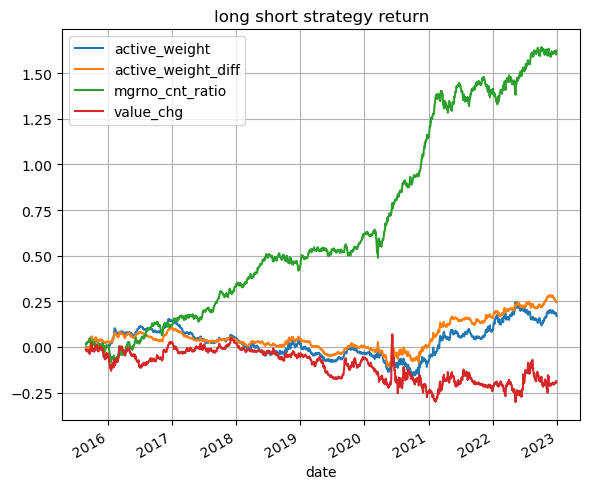

In [16]:
fig, ax = plt.subplots(figsize=(6, 5))
for idx, feature in enumerate(['active_weight','active_weight_diff','mgrno_cnt_ratio','value_chg',]):
    ret2 = get_long_short_returns_daily(holdings_stk_merge, f'{feature}', price_vol)[['daily_ret']].cumsum().rename(columns= {'daily_ret': f"{feature}"})
    ret2.plot(ax = ax, grid = True, title="long short strategy return", label = feature)
plt.tight_layout()

/var/folders/8_/z3_k3qn91fl5r5jxz__cs5dr0000gn/T/ipykernel_56934/1174449751.py:56: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  frame[f'{signal_col}Group'] = frame.groupby('date')[signal_col].apply(lambda x: pd.qcut(x, n_bins, labels=[i + 1 for i in range(n_bins)], duplicates='drop'))
/var/folders/8_/z3_k3qn91fl5r5jxz__cs5dr0000gn/T/ipykernel_56934/1174449751.py:56: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(...

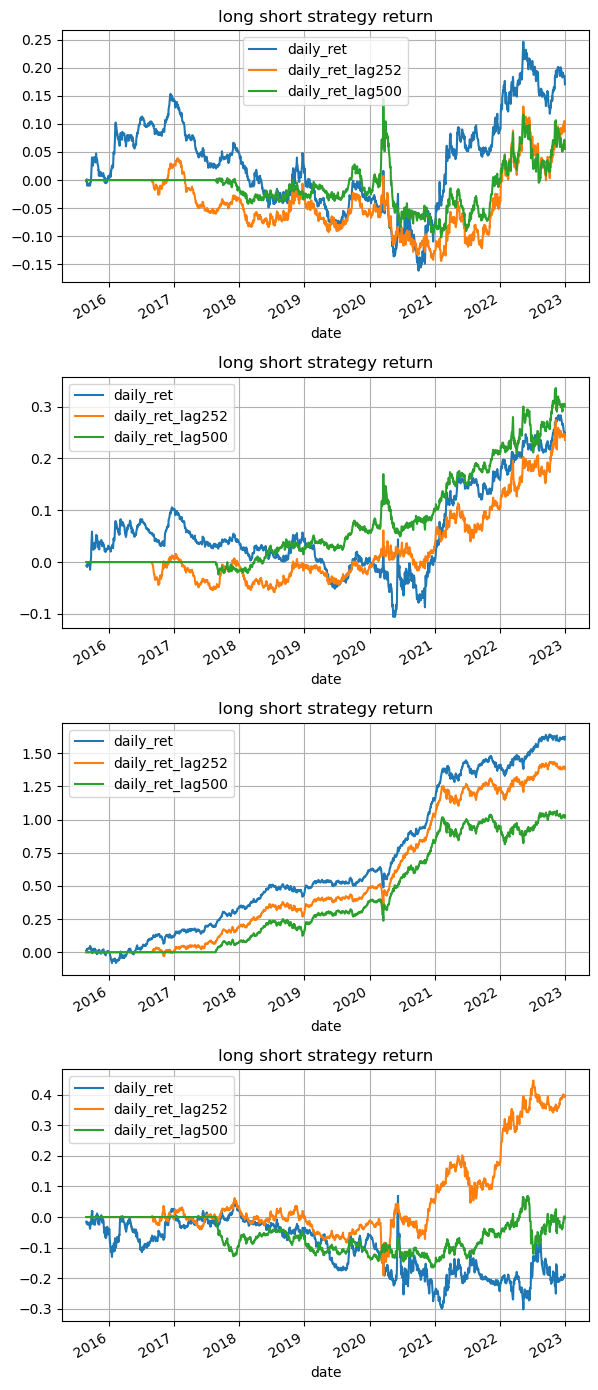

In [17]:
fig, axes = plt.subplots(4, 1, figsize=(6, 14))
for idx, feature in enumerate(['active_weight','active_weight_diff','mgrno_cnt_ratio','value_chg',]):
    ret2 = get_long_short_returns_daily(holdings_stk_merge, f'{feature}', price_vol).cumsum()
    ret2.plot(ax = axes[idx], grid = True, title="long short strategy return", label = feature)
plt.tight_layout()

In [18]:
# pd.options.display.float_format = '{:.1%}'.format

stats_long_only = []
stats_long_short = []

for feature in ['active_weight', 'active_weight_diff', 'value_chg', 'mgrno_cnt_ratio']:
    ret2 = get_long_short_returns_daily(holdings_stk_merge, f'{feature}', price_vol)
    for col in ret2.columns:
        lag = col.split('_')[-1]
        stats_long_short.append(backtest(ret2[col], f'{feature}_{lag}'))
    
perf = pd.concat(stats_long_short).T
#perf.columns = ['active_weight', 'active_weight_diff', 'value_chg', 'mgrno_cnt_ratio']
perf.loc['sharpe'] = perf.loc['sharpe'].apply('{:.2f}'.format)
perf

/var/folders/8_/z3_k3qn91fl5r5jxz__cs5dr0000gn/T/ipykernel_56934/1174449751.py:56: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  frame[f'{signal_col}Group'] = frame.groupby('date')[signal_col].apply(lambda x: pd.qcut(x, n_bins, labels=[i + 1 for i in range(n_bins)], duplicates='drop'))
/var/folders/8_/z3_k3qn91fl5r5jxz__cs5dr0000gn/T/ipykernel_56934/1174449751.py:56: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(...

,active_weight_ret,active_weight_lag252,active_weight_lag500,active_weight_diff_ret,active_weight_diff_lag252,active_weight_diff_lag500,value_chg_ret,value_chg_lag252,value_chg_lag500,mgrno_cnt_ratio_ret,mgrno_cnt_ratio_lag252,mgrno_cnt_ratio_lag500
start_date,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28
end_date,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30
n_days,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849
n_pos_day,867,1041,1171,894,1052,1189,866,1049,1165,1001,1122,1223
ret_annual,0.02321,0.01179,0.00757,0.03348,0.03212,0.04089,-0.02659,0.05397,-0.00055,0.22117,0.19050,0.14055
std_annual,0.09737,0.08553,0.07701,0.08044,0.06727,0.05957,0.15350,0.10967,0.08642,0.13178,0.12580,0.12753
sharpe,0.24,0.14,0.10,0.42,0.48,0.69,-0.17,0.49,-0.01,1.68,1.51,1.10
mdd,0.31458,0.18255,0.24744,0.21147,0.07720,0.12036,0.37127,0.25228,0.18865,0.15426,0.16421,0.22361


In [19]:
# pd.options.display.float_format = '{:.1%}'.format

stats_long_only = []
stats_long_short = []

for feature in ['active_weight', 'active_weight_diff', 'value_chg', 'mgrno_cnt_ratio']:
    ret2 = get_long_short_returns_daily(holdings_stk_merge, f'{feature}', price_vol)
    for col in ret2.columns:
        lag = col.split('_')[-1]
        stats_long_short.append(backtest(ret2[col], f'{feature}_{lag}'))
    
perf = pd.concat(stats_long_short).T
#perf.columns = ['active_weight', 'active_weight_diff', 'value_chg', 'mgrno_cnt_ratio']
perf.loc['sharpe'] = perf.loc['sharpe'].apply('{:.2f}'.format)
perf

/var/folders/8_/z3_k3qn91fl5r5jxz__cs5dr0000gn/T/ipykernel_56934/1174449751.py:56: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  frame[f'{signal_col}Group'] = frame.groupby('date')[signal_col].apply(lambda x: pd.qcut(x, n_bins, labels=[i + 1 for i in range(n_bins)], duplicates='drop'))
/var/folders/8_/z3_k3qn91fl5r5jxz__cs5dr0000gn/T/ipykernel_56934/1174449751.py:56: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(...

,active_weight_ret,active_weight_lag252,active_weight_lag500,active_weight_diff_ret,active_weight_diff_lag252,active_weight_diff_lag500,value_chg_ret,value_chg_lag252,value_chg_lag500,mgrno_cnt_ratio_ret,mgrno_cnt_ratio_lag252,mgrno_cnt_ratio_lag500
start_date,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28,2015-08-28
end_date,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30,2022-12-30
n_days,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849
n_pos_day,867,1041,1171,894,1052,1189,866,1049,1165,1001,1122,1223
ret_annual,0.02321,0.01179,0.00757,0.03348,0.03212,0.04089,-0.02659,0.05397,-0.00055,0.22117,0.19050,0.14055
std_annual,0.09737,0.08553,0.07701,0.08044,0.06727,0.05957,0.15350,0.10967,0.08642,0.13178,0.12580,0.12753
sharpe,0.24,0.14,0.10,0.42,0.48,0.69,-0.17,0.49,-0.01,1.68,1.51,1.10
mdd,0.31458,0.18255,0.24744,0.21147,0.07720,0.12036,0.37127,0.25228,0.18865,0.15426,0.16421,0.22361


## visualization

In [20]:
# choose the stock that we care about
stk_focus = ["MICROSOFT CORP", "UNITED HEALTHCARE CORP", 'COSTCO WHOLESALE CORP']
permno_focus = [10107, 87055, 92655]
holdings_stk_focus = holdings_stk[holdings_stk.index.get_level_values(1).isin(permno_focus)].reset_index().set_index(['permno', 'date']).sort_index()

# change datetime index to date
holdings_stk_focus = holdings_stk_focus.reset_index()
holdings_stk_focus['date'] = holdings_stk_focus['date'].dt.date
holdings_stk_focus = holdings_stk_focus.set_index(['permno', 'date'])

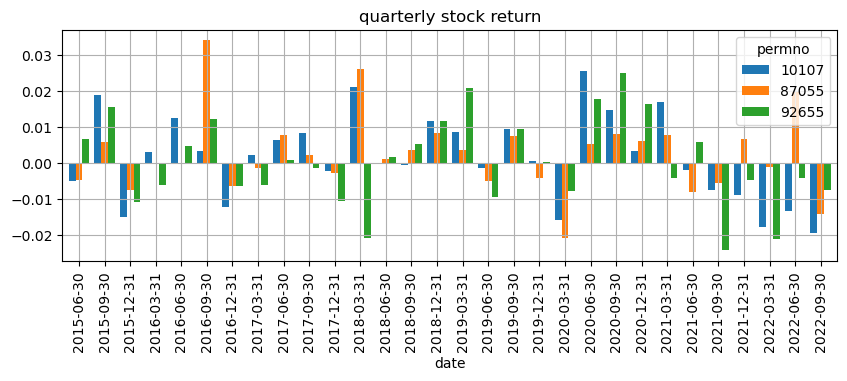

In [21]:
holdings_stk_focus['ret'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'quarterly stock return', width=0.8);

### weight

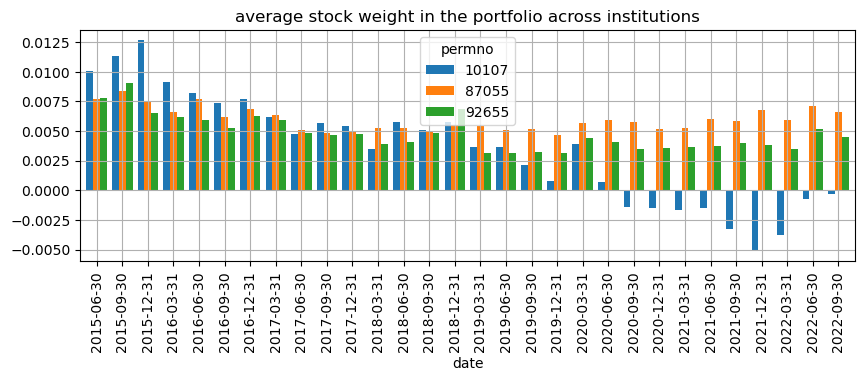

In [23]:
holdings_stk_focus['active_weight'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'average stock weight in the portfolio across institutions', width=0.8);

<Axes: >

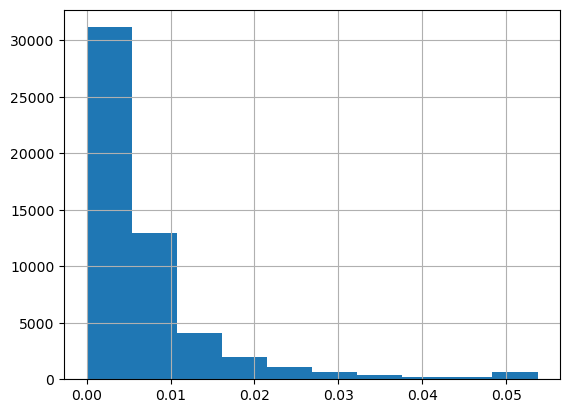

In [25]:
holdings_stk['active_weight'].clip(0, holdings_stk['active_weight'].quantile(0.99)).hist()

### weight_diff

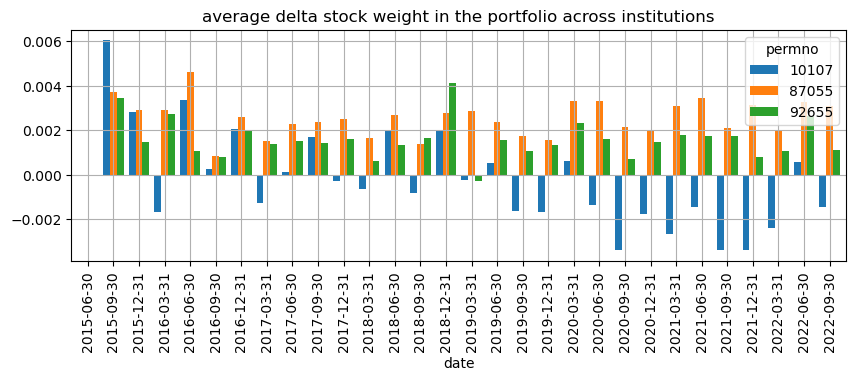

In [26]:
holdings_stk_focus['active_weight_diff'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'average delta stock weight in the portfolio across institutions', width=0.8);

<Axes: >

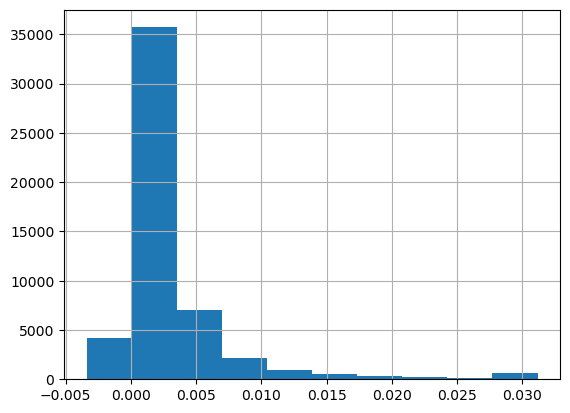

In [27]:
holdings_stk['active_weight_diff'].hist()

### buysale count

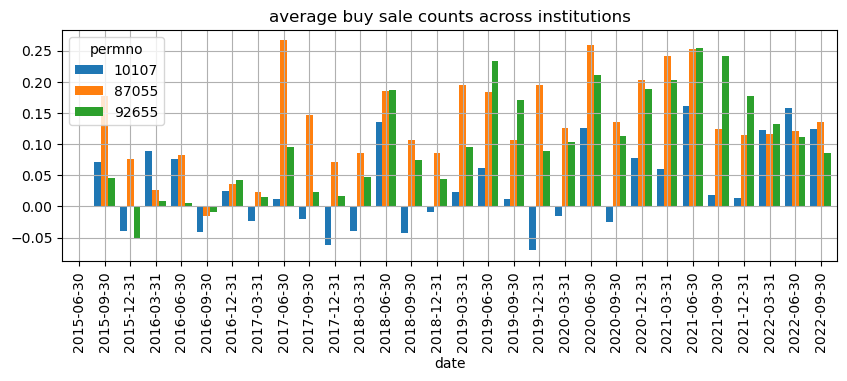

In [28]:
holdings_stk_focus['buysale'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'average buy sale counts across institutions', width=0.8);

<Axes: >

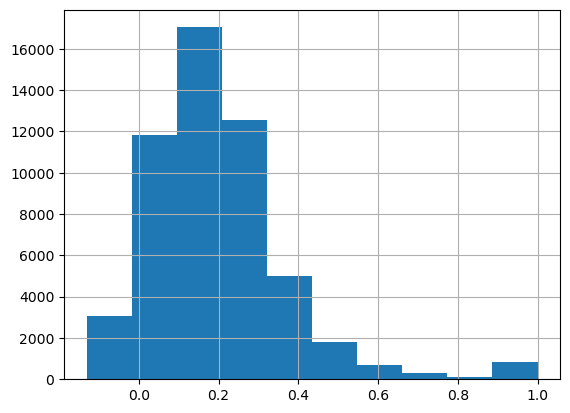

In [29]:
holdings_stk['buysale'].clip(holdings_stk['buysale'].quantile(0.01), holdings_stk['buysale'].quantile(0.99)).hist()

### mgrno_cnt_ratio_chg

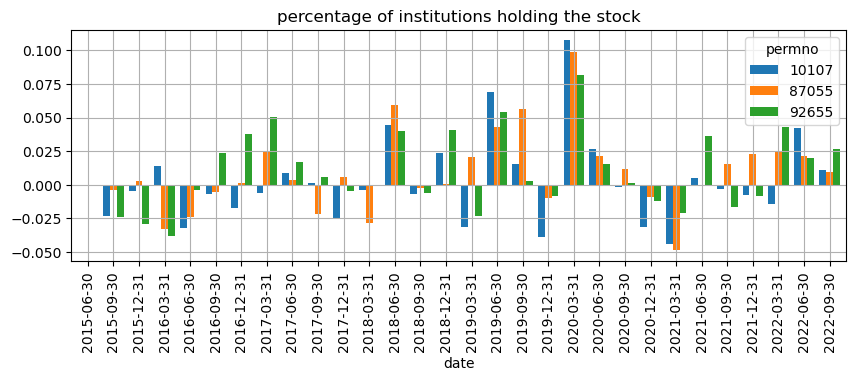

In [30]:
holdings_stk_focus['mgrno_cnt_ratio_chg'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'percentage of institutions holding the stock', width=0.8);

<Axes: >

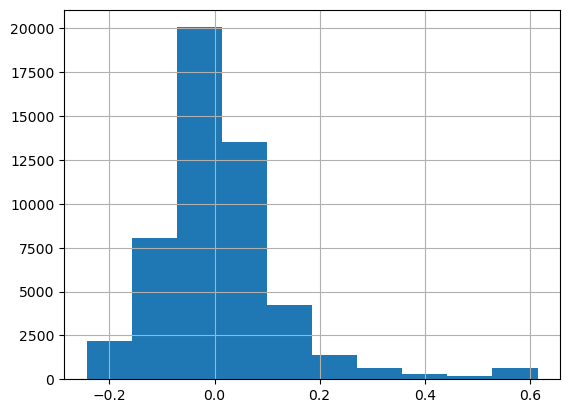

In [31]:
holdings_stk['mgrno_cnt_ratio_chg'].clip(holdings_stk['mgrno_cnt_ratio_chg'].quantile(0.01), holdings_stk['mgrno_cnt_ratio_chg'].quantile(0.99)).hist()

### value change

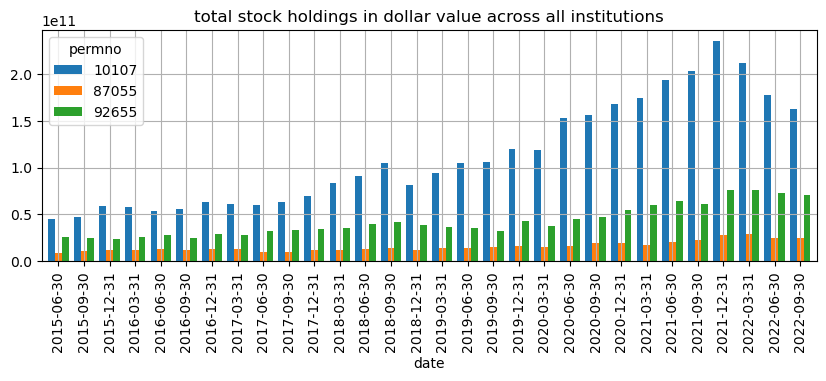

In [32]:
holdings_stk_focus['total_value'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'total stock holdings in dollar value across all institutions', width=0.8);

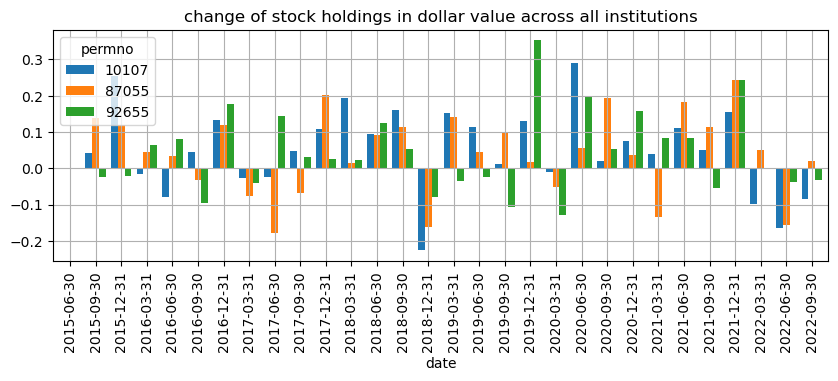

In [33]:
holdings_stk_focus['value_chg'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'change of stock holdings in dollar value across all institutions', width=0.8);

<Axes: >

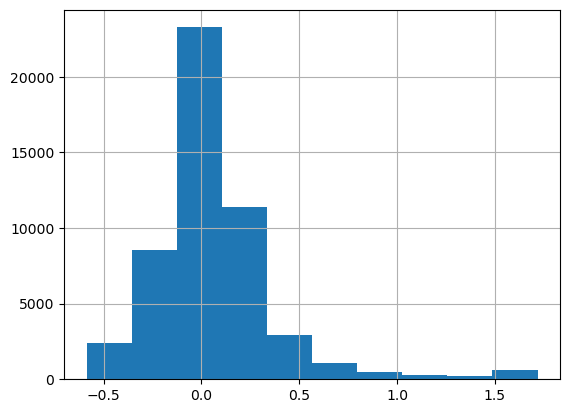

In [34]:
holdings_stk['value_chg'].clip(holdings_stk['value_chg'].quantile(0.01), holdings_stk['value_chg'].quantile(0.99)).hist()